In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Model,load_model

# 1. Upload and show train data

### (train data: 2020/12/1 ~ 2020/12/10, test data: 2021/3/14)

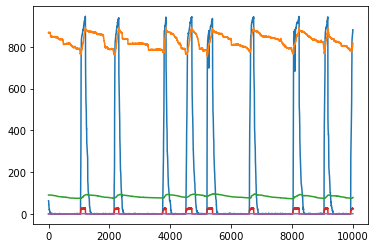

In [8]:
UsingFeatures = ['pres_cm_in','pres_mr','temp_cm_oil','curr_u','valv_1']
datas = []
for i in range(1,11):
    data = pd.read_csv('./data/205train/205train_cmsd_tc1_2020_12_%02d.csv' %i)
    data = data[UsingFeatures]
    datas.append(data)
    
plt.plot(datas[0][0:10000])
plt.show()

# 2. Preprocessing to train

In [14]:
def moving_window(data,sequence_num,step):
    X_train = []
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

def normalization(data):
    pres_cm_in_max = 1000
    pres_cm_in_min = 0
    pres_mr_max = 900
    pres_mr_min = 600
    temp_cm_oil_max = 120
    temp_cm_oil_min = 20
    curr_u_max = 30
    curr_u_min = 0
    data.iloc[:,0]  = (data.iloc[:,0] -pres_cm_in_min)/(pres_cm_in_max-pres_cm_in_min)
    data.iloc[:,1]  = (data.iloc[:,1] -pres_mr_min)/(pres_mr_max-pres_mr_min)
    data.iloc[:,2]  = (data.iloc[:,2] -temp_cm_oil_min)/(temp_cm_oil_max-temp_cm_oil_min)
    data.iloc[:,3]  = (data.iloc[:,3] -curr_u_min)/(curr_u_max-curr_u_min)
    return data

datas_2 = []
for data in datas:
    data = normalization(data)
    data = moving_window(data,100,10)
    datas_2.append(data)
data = np.concatenate(datas_2)
data.shape

(320604, 100, 5)

In [15]:
#결측치 제거
nan_list = list(np.where(np.isnan(data)==True)[0])
train = np.delete(data, nan_list,0)

# 3. LSTM AE Model

In [18]:
def autoencoder_model(X):    
    x = tf.keras.layers.Input(shape=[X.shape[1],X.shape[2]])
    H = LSTM(8,activation = 'sigmoid', return_sequences = True)(x)
    H = LSTM(16,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(8,activation = 'sigmoid', return_sequences = False)(H)
    H = RepeatVector(X.shape[1])(H)
    H = LSTM(16,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(8,activation = 'sigmoid', return_sequences = True)(H)
    Y = LSTM(X.shape[2],activation = 'sigmoid', return_sequences = True)(H)
    model = Model(x, Y)
    return model

LSTM_AE = autoencoder_model(train)
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
LSTM_AE.compile(optimizer=adam,loss='mae')
LSTM_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 5)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 8)            448       
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 16)           1600      
_________________________________________________________________
lstm_11 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 100, 8)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 16)           1600      
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 8)            800 

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = LSTM_AE.fit(train,train,epochs = 100,batch_size = 20, callbacks=[early_stopping],validation_split = 0.05)

Epoch 1/100
15225/15225 [==============================] - 1261s 82ms/step - loss: 0.1714 - val_loss: 0.0613
Epoch 2/100
15225/15225 [==============================] - 1266s 83ms/step - loss: 0.1191 - val_loss: 0.0502
Epoch 3/100
15225/15225 [==============================] - 1248s 82ms/step - loss: 0.1091 - val_loss: 0.0488
Epoch 4/100
15225/15225 [==============================] - 1243s 82ms/step - loss: 0.1079 - val_loss: 0.0486
Epoch 5/100
15225/15225 [==============================] - 1253s 82ms/step - loss: 0.1073 - val_loss: 0.0485
Epoch 6/100
15225/15225 [==============================] - 1265s 83ms/step - loss: 0.1076 - val_loss: 0.0484
Epoch 7/100
15225/15225 [==============================] - 1260s 83ms/step - loss: 0.1067 - val_loss: 0.0491
Epoch 8/100
15225/15225 [==============================] - 1254s 82ms/step - loss: 0.1074 - val_loss: 0.0486
Epoch 9/100
15225/15225 [==============================] - 1256s 82ms/step - loss: 0.1075 - val_loss: 0.0488
Epoch 10/100
15225/

In [20]:
LSTM_AE.save("LSTM_AE_1.h5")

# 4. CNN - LSTM AE Model

In [21]:
def autoencoder_model(X):    
    x = tf.keras.layers.Input(shape=[X.shape[1],X.shape[2],1])
    H = tf.keras.layers.Conv2D(6, kernel_size = 2, activation = 'sigmoid')(x)
    H = tf.keras.layers.MaxPool2D(pool_size=(2, 1), strides=None, padding='valid', data_format=None)(H)
    H = tf.keras.layers.Conv2D(12, kernel_size = 4, activation = 'sigmoid')(H)
    H = tf.keras.layers.Flatten()(H)
    H = tf.keras.layers.Dense(64, activation = 'sigmoid')(H)
    H = tf.keras.layers.Dense(16, activation = 'sigmoid')(H)
    H = RepeatVector(X.shape[1])(H)
    H = LSTM(16,activation = 'sigmoid', return_sequences = True)(H)
    H = LSTM(8,activation = 'sigmoid', return_sequences = True)(H)
    Y = LSTM(X.shape[2],activation = 'sigmoid', return_sequences = True)(H)
    model = Model(x, Y)
    return model

CNN_LSTM_AE = autoencoder_model(train)

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
CNN_LSTM_AE.compile(optimizer=adam,loss='mae')
CNN_LSTM_AE.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 5, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 4, 6)          30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 4, 6)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 1, 12)         1164      
_________________________________________________________________
flatten (Flatten)            (None, 552)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                35392     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = CNN_LSTM_AE.fit(train,train,epochs = 100,batch_size = 20, callbacks=[early_stopping],validation_split = 0.05)

Epoch 1/100
15225/15225 [==============================] - 687s 45ms/step - loss: 0.1699 - val_loss: 0.0954
Epoch 2/100
15225/15225 [==============================] - 658s 43ms/step - loss: 0.1324 - val_loss: 0.0491
Epoch 3/100
15225/15225 [==============================] - 663s 44ms/step - loss: 0.1082 - val_loss: 0.0483
Epoch 4/100
15225/15225 [==============================] - 671s 44ms/step - loss: 0.1072 - val_loss: 0.0484
Epoch 5/100
15225/15225 [==============================] - 670s 44ms/step - loss: 0.1070 - val_loss: 0.0482
Epoch 6/100
15225/15225 [==============================] - 670s 44ms/step - loss: 0.1072 - val_loss: 0.0483
Epoch 7/100
15225/15225 [==============================] - 675s 44ms/step - loss: 0.1065 - val_loss: 0.0478
Epoch 8/100
15225/15225 [==============================] - 676s 44ms/step - loss: 0.1063 - val_loss: 0.0476
Epoch 9/100
15225/15225 [==============================] - 664s 44ms/step - loss: 0.1065 - val_loss: 0.0475
Epoch 10/100
15225/15225 [==

In [23]:
CNN_LSTM_AE.save("CNN_LSTM_AE_1.h5")